In [1]:
#%%capture
!pip install yfinance==0.2.58
#!pip install yfinance
#!pip install twelvedata
import numpy as np
import pandas as pd
import yfinance as yf
!pip show yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.63
    Uninstalling yfinance-0.2.63:
      Successfully uninstalled yfinance-0.2.63
Name: yfinance
Version: 0.2.58
Summary: Download market data from Yahoo! Finance API
Home-page: https://github.com/ranaroussi/yfinance
Author: Ran Aroussi
Author-email: ran@aroussi.com
License: Apache
Location: /usr/local/lib/python3.11/dist-packages
Requires: beautifulsoup4, curl_cffi, frozendict, multitasking, numpy, pandas, peewee, platformdirs, pytz, requests
Required-by: 


In [53]:
ticker = "1120.SR"
"""
ticker = "1120:Tadawul"
from twelvedata import TDClient

# Initialize TDClient with your API key
td = TDClient(apikey="2ced3e308ffe4a2ea90b4e4ca728fa9d")

ts = td.time_series(
    symbol=ticker,
    interval="1day",
    outputsize=100  # Number of data points to retrieve
)

# Convert to pandas DataFrame for easier manipulation
df = ts.as_pandas()
"""
data = yf.download(ticker, start="2024-01-01", end="2025-06-23")
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR
Date,,,,,
2024-01-01,83.158165,83.637187,82.870749,82.870749,2871681
2024-01-02,83.253975,83.253975,82.295931,83.158172,3495693
2024-01-03,81.146278,82.870760,81.146278,82.487541,4288840
2024-01-04,83.828796,83.828796,79.805017,80.475645,5486572
2024-01-07,85.074257,86.128103,84.020403,84.307819,5900413
...,...,...,...,...,...
2025-06-16,92.599998,93.400002,91.199997,91.199997,3653317
2025-06-17,91.699997,93.099998,91.500000,92.599998,3959192


In [54]:
# Find the lowest price for the stock over the last week
data["prv_low_1"] = data["Low"].shift(1)
data["prv_low_2"] = data["Low"].shift(2)
data["prv_low_3"] = data["Low"].shift(3)
data["prv_low_4"] = data["Low"].shift(4)
data["prv_low_5"] = data["Low"].shift(5)
data["Low_Last_5d"] = data[["prv_low_1", "prv_low_2","prv_low_3","prv_low_4","prv_low_5"]].values.min(1)
data = data.drop(["prv_low_1", "prv_low_2", "prv_low_3", "prv_low_4", "prv_low_5"], axis=1)

# Find the highest price for the stock over the last week
data['prv_high_1'] = data["High"].shift(1)
data['prv_high_2'] = data["High"].shift(2)
data['prv_high_3'] = data["High"].shift(3)
data['prv_high_4'] = data["High"].shift(4)
data['prv_high_5'] = data["High"].shift(5)
data["High_Last_5d"] = data[["prv_high_1", "prv_high_2","prv_high_3","prv_high_4","prv_high_5"]].values.max(1)
data = data.drop(["prv_high_1", "prv_high_2", "prv_high_3", "prv_high_4", "prv_high_5"], axis=1)
data.tail(2)

Price,Close,High,Low,Open,Volume,Low_Last_5d,High_Last_5d
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,
Date,,,,,,,
2025-06-19,91.199997,91.599998,90.5,91.099998,3742444,88.099998,93.800003
2025-06-22,90.099998,92.199997,90.0,91.199997,2380902,88.099998,93.400002


In [55]:
# Create boolean variable marking whether stock dropped at least six percent in the last week (five days)
data["six_percent_of_close_price"] = .94*data["Close"]
data["Close"] = 1*data["Close"]
data["six_percent_of_close_price_within_last_five_days"] = np.where((data['Low_Last_5d'] <= data['six_percent_of_close_price']) & (data['six_percent_of_close_price'] <= data['High_Last_5d']), True, False)

In [56]:
# Create boolean variable marking whether current close price is greater than yesterdays close price
data["Last_Close"] = data["Close"].shift(1)
data["close_diff"] = data["Close"].values.reshape(data.shape[0]) - data["Last_Close"].values.reshape(data.shape[0])
data["up_from_yesterday"] = np.where((data["close_diff"] > 0), True, False)
data.tail(5)

Price,Close,High,Low,Open,Volume,Low_Last_5d,High_Last_5d,six_percent_of_close_price,six_percent_of_close_price_within_last_five_days,Last_Close,close_diff,up_from_yesterday
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,
Date,,,,,,,,,,,,
2025-06-16,92.599998,93.400002,91.199997,91.199997,3653317,88.099998,95.199997,87.043999,False,91.199997,1.400002,True
2025-06-17,91.699997,93.099998,91.500000,92.599998,3959192,88.099998,95.199997,86.197997,False,92.599998,-0.900002,False
2025-06-18,91.500000,91.699997,90.500000,91.000000,1696730,88.099998,95.199997,86.010000,False,91.699997,-0.199997,False
2025-06-19,91.199997,91.599998,90.500000,91.099998,3742444,88.099998,93.800003,85.727997,False,91.500000,-0.300003,False
2025-06-22,90.099998,92.199997,90.000000,91.199997,2380902,88.099998,93.400002,84.693999,False,91.199997,-1.099998,False


In [58]:
# Buy stock if price dropped at least seven percent in last week and current close price is greater than yesterdays close price
data["shortsell"] = data["six_percent_of_close_price_within_last_five_days"] & data["up_from_yesterday"]
data["shortsellcumsum"] = data["shortsell"].cumsum().astype('int64')
data = data.drop(["Last_Close","close_diff","six_percent_of_close_price","up_from_yesterday","six_percent_of_close_price_within_last_five_days","Low_Last_5d","High_Last_5d"], axis=1)

# Add numerical columns of stocks current close price increased and decrease by one percent for final analysis
data["Close_up1%"] = 1.01*data["Close"]
data["Close_down1%"] = .99*data["Close"]
data.tail(10)

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,
Date,,,,,,,,,
2025-06-03,90.000000,91.099998,89.800003,91.000000,2996259,False,12,90.900000,89.100000
2025-06-04,93.300003,93.400002,90.099998,90.300003,6143607,False,12,94.233003,92.367003
2025-06-11,93.699997,95.199997,93.199997,94.000000,4913697,True,13,94.636997,92.762997
2025-06-12,92.599998,93.800003,92.000000,93.699997,3442999,False,13,93.525998,91.673998
2025-06-15,91.199997,92.000000,88.099998,88.099998,2784804,False,13,92.111997,90.287997
2025-06-16,92.599998,93.400002,91.199997,91.199997,3653317,False,13,93.525998,91.673998
2025-06-17,91.699997,93.099998,91.500000,92.599998,3959192,False,13,92.616997,90.782997
2025-06-18,91.500000,91.699997,90.500000,91.000000,1696730,False,13,92.415000,90.585000


In [10]:
# view dates where we buy the stock + the two days after
#buyclause = data['buy']==True
#view = data[buyclause.shift(2)|buyclause.shift()|buyclause]
#view

In [59]:
data.loc[(data.shortsell == False), 'Close_up1%'] = np.nan
data.loc[(data.shortsell == False), 'Close_down1%'] = np.nan
data.tail(10)

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,
Date,,,,,,,,,
2025-06-03,90.000000,91.099998,89.800003,91.000000,2996259,False,12,NaN,NaN
2025-06-04,93.300003,93.400002,90.099998,90.300003,6143607,False,12,NaN,NaN
2025-06-11,93.699997,95.199997,93.199997,94.000000,4913697,True,13,94.636997,92.762997
2025-06-12,92.599998,93.800003,92.000000,93.699997,3442999,False,13,NaN,NaN
2025-06-15,91.199997,92.000000,88.099998,88.099998,2784804,False,13,NaN,NaN
2025-06-16,92.599998,93.400002,91.199997,91.199997,3653317,False,13,NaN,NaN
2025-06-17,91.699997,93.099998,91.500000,92.599998,3959192,False,13,NaN,NaN
2025-06-18,91.500000,91.699997,90.500000,91.000000,1696730,False,13,NaN,NaN


In [60]:
data["Close_up1%"] = data["Close_up1%"].ffill()
data["Close_down1%"] = data["Close_down1%"].ffill()
data.tail(10)

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,
Date,,,,,,,,,
2025-06-03,90.000000,91.099998,89.800003,91.000000,2996259,False,12,98.070998,96.128998
2025-06-04,93.300003,93.400002,90.099998,90.300003,6143607,False,12,98.070998,96.128998
2025-06-11,93.699997,95.199997,93.199997,94.000000,4913697,True,13,94.636997,92.762997
2025-06-12,92.599998,93.800003,92.000000,93.699997,3442999,False,13,94.636997,92.762997
2025-06-15,91.199997,92.000000,88.099998,88.099998,2784804,False,13,94.636997,92.762997
2025-06-16,92.599998,93.400002,91.199997,91.199997,3653317,False,13,94.636997,92.762997
2025-06-17,91.699997,93.099998,91.500000,92.599998,3959192,False,13,94.636997,92.762997
2025-06-18,91.500000,91.699997,90.500000,91.000000,1696730,False,13,94.636997,92.762997


In [61]:
data["buyup"] = np.where((data["Close"].values.reshape(data.shape[0])-data["Close_up1%"].values.reshape(data.shape[0]) > 0),True,False)
data["buydown"] = np.where((data["Close_down1%"].values.reshape(data.shape[0])-data["Close"].values.reshape(data.shape[0]) > 0),True,False)
data["buy"] = data["buydown"]|data["buyup"]
data["buycumsum"] = data["buy"].cumsum().astype('int64')
#data.to_csv('out.csv', index=False)
#data = pd.read_csv('out.csv')
#data.tail(10)

In [ ]:
#from collections import defaultdict
#dates = ["2024-01-29","2024-06-10","2024-08-27","2024-10-09","2024-10-14","2024-11-12","2025-01-05","2025-02-06","2025-04-16","2025-06-12"]
#values = []

In [18]:
data.loc[data.shortsellcumsum==x].columns

MultiIndex([(       'Close', '1120.SR'),
            (        'High', '1120.SR'),
            (         'Low', '1120.SR'),
            (        'Open', '1120.SR'),
            (      'Volume', '1120.SR'),
            (         'buy',        ''),
            (   'buycumsum',        ''),
            (  'Close_up1%',        ''),
            ('Close_down1%',        ''),
            (      'sellup',        ''),
            (    'selldown',        ''),
            (        'sell',        ''),
            (  'sellcumsum',        '')],
           names=['Price', 'Ticker'])

In [19]:
#for x in range(1,data["buycumsum"].max()+1):
#  print(x)
#  print(data.loc[data.buycumsum==x]["Date"])

In [63]:
data.loc[data.shortsellcumsum==1]

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,,
Date,,,,,,,,,,,,,
2024-01-28,87.660980,87.948396,84.786850,84.786850,6192332,True,1,88.53759,86.78437,False,False,False,0
2024-01-29,86.702927,88.619013,86.607124,87.852576,4296455,False,1,88.53759,86.78437,False,True,True,1
2024-01-30,84.403625,87.469369,83.924604,86.702931,5328066,False,1,88.53759,86.78437,False,True,True,2
2024-01-31,80.475647,84.307821,80.475647,83.253974,9098814,False,1,88.53759,86.78437,False,True,True,3
2024-02-01,82.391739,83.253979,79.805024,80.284046,4488470,False,1,88.53759,86.78437,False,True,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-02,74.938034,74.938034,74.938034,74.938034,0,False,1,88.53759,86.78437,False,True,True,80
2024-06-03,75.811668,76.102881,73.481987,73.481987,6147385,False,1,88.53759,86.78437,False,True,True,81


In [64]:
data.loc[data.shortsellcumsum==2]
#dates = ["2024-01-29","2024-06-10","2024-08-27","2024-10-09","2024-10-14","2024-11-12","2025-01-05","2025-02-06","2025-04-16","2025-06-12"]
#values = [87.66-86.70,79.40-78.52,]

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,,
Date,,,,,,,,,,,,,
2024-06-09,79.403259,80.082746,76.879433,77.461859,7480322,True,2,80.197292,78.609227,False,False,False,84
2024-06-10,78.529625,81.441725,78.141343,79.500325,4817863,False,2,80.197292,78.609227,False,True,True,85
2024-06-11,77.655998,79.112048,77.558930,78.626698,8729365,False,2,80.197292,78.609227,False,True,True,86
2024-06-12,77.461861,78.626698,77.364785,77.655998,5036103,False,2,80.197292,78.609227,False,True,True,87
2024-06-13,76.685295,78.238414,76.685295,77.947208,11280745,False,2,80.197292,78.609227,False,True,True,88
2024-06-23,78.626701,79.014983,77.267720,77.656001,3566797,False,2,80.197292,78.609227,False,False,False,88
2024-06-24,78.917908,80.179813,77.753063,78.044276,8602916,False,2,80.197292,78.609227,False,False,False,88
2024-06-25,79.597397,79.791534,78.238415,78.335484,4505390,False,2,80.197292,78.609227,False,False,False,88


In [65]:
data.loc[data.shortsellcumsum==3]
#dates = ["2024-01-29","2024-06-10","2024-08-27","2024-10-09","2024-10-14","2024-11-12","2025-01-05","2025-02-06","2025-04-16","2025-06-12"]
#values = [87.66-86.70,79.40-78.52,87.77-86.68,]

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,,
Date,,,,,,,,,,,,,
2024-08-21,87.772591,88.166633,84.915793,85.211327,10209827,True,3,88.650317,86.894865,False,False,False,124
2024-08-22,87.575577,88.166637,86.590475,87.674085,4519726,False,3,88.650317,86.894865,False,False,False,124
2024-08-25,87.378548,88.560675,87.083022,88.166632,2777019,False,3,88.650317,86.894865,False,False,False,124
2024-08-26,87.280045,87.772596,86.984518,87.280045,2598828,False,3,88.650317,86.894865,False,False,False,124
2024-08-27,86.688980,87.378549,86.590471,87.280040,4769451,False,3,88.650317,86.894865,False,True,True,125
2024-08-28,85.408348,86.886001,85.408348,86.491966,3671416,False,3,88.650317,86.894865,False,True,True,126
2024-08-29,86.787491,86.787491,85.408346,85.506863,9230598,False,3,88.650317,86.894865,False,True,True,127
2024-09-01,87.477066,87.477066,86.590473,86.688981,3098681,False,3,88.650317,86.894865,False,False,False,127


In [66]:
data.loc[data.shortsellcumsum==4]
#dates = ["2024-01-29","2024-06-10","2024-08-27","2024-10-09","2024-10-14","2024-11-12","2025-01-05","2025-02-06","2025-04-16","2025-06-12"]
#values = [87.66-86.70, 79.40-78.52, 87.77-86.68, 84.42-82.74, ]

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,,
Date,,,,,,,,,,,,,
2024-10-08,84.423241,84.718774,82.157511,82.945588,4906428,True,4,85.267473,83.579008,False,False,False,143
2024-10-09,82.748573,85.112820,82.748573,84.521760,3509588,False,4,85.267473,83.579008,False,True,True,144


In [68]:
data.loc[data.shortsellcumsum==5]

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,,
Date,,,,,,,,,,,,,
2024-10-10,84.127716,84.620267,82.650063,82.945589,2545027,True,5,84.968993,83.286439,False,False,False,144


In [69]:
data.loc[data.shortsellcumsum==6]
#dates = ["2024-01-29","2024-06-10","2024-08-27","2024-10-09","2024-10-14","2024-11-12","2025-01-05","2025-02-06","2025-04-16","2025-06-12"]
#values = [87.66-86.70, 79.40-78.52, 87.77-86.68, 84.42-82.74, 85.11-83.73, ]

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,,
Date,,,,,,,,,,,,,
2024-10-13,85.112816,85.506858,84.127714,84.127714,2117743,True,6,85.963944,84.261688,False,False,False,144
2024-10-14,83.733673,85.112817,83.142613,84.915793,5350604,False,6,85.963944,84.261688,False,True,True,145
2024-10-15,83.733673,84.718775,83.536656,84.718775,5066635,False,6,85.963944,84.261688,False,True,True,146
2024-10-16,83.635170,84.127721,83.438145,83.832187,2832252,False,6,85.963944,84.261688,False,True,True,147
2024-10-17,81.172409,83.930690,81.172409,83.536655,8074439,False,6,85.963944,84.261688,False,True,True,148
2024-10-20,81.467934,82.354527,80.581348,81.467934,4654728,False,6,85.963944,84.261688,False,True,True,149
2024-10-21,83.733673,84.127715,81.369427,81.369427,7711297,False,6,85.963944,84.261688,False,True,True,150
2024-10-22,84.521759,84.521759,83.536657,84.029208,5278312,False,6,85.963944,84.261688,False,False,False,150


In [70]:
data.loc[data.shortsellcumsum==7]

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,,
Date,,,,,,,,,,,,,
2024-11-10,92.402573,94.569794,91.614488,91.712997,9407282,True,7,93.326598,91.478547,False,False,False,160


In [ ]:
data.loc[data.buycumsum==8]
dates = ["2024-01-29","2024-06-10","2024-08-27","2024-10-09","2024-10-14","2024-11-12","2025-01-05","2025-02-06","2025-04-16","2025-06-12"]
values = [87.66-86.70, 79.40-78.52, 87.77-86.68, 84.42-82.74, 85.11-83.73, 92.99-92.00, ]

Price,Close,High,Low,Open,Volume,buy,buycumsum,Close_up1%,Close_down1%,sellup,selldown,sell,sellcumsum
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,,
Date,,,,,,,,,,,,,
2024-11-11,92.993637,94.471290,92.107044,92.402577,7037001,True,8,93.923573,92.063701,False,False,False,160
2024-11-12,92.008537,93.880233,92.008537,93.092148,4343489,False,8,93.923573,92.063701,False,True,True,161
2024-11-13,90.235344,91.515980,89.939818,91.121937,4681926,False,8,93.923573,92.063701,False,True,True,162
2024-11-14,88.954720,90.924924,88.954720,89.939822,5026623,False,8,93.923573,92.063701,False,True,True,163
2024-11-17,88.954720,88.954720,88.954720,88.954720,0,False,8,93.923573,92.063701,False,True,True,164
2024-11-18,90.136841,90.136841,87.378552,87.969619,4864639,False,8,93.923573,92.063701,False,True,True,165
2024-11-19,91.910027,92.008535,89.644289,90.235349,4316538,False,8,93.923573,92.063701,False,True,True,166
2024-11-20,91.614494,92.501088,91.220452,91.811512,3249886,False,8,93.923573,92.063701,False,True,True,167


In [71]:
data.loc[data.shortsellcumsum==9]
#dates = ["2024-01-29","2024-06-10","2024-08-27","2024-10-09","2024-10-14","2024-11-12","2025-01-05","2025-02-06","2025-04-16","2025-06-12"]
#values = [87.66-86.70, 79.40-78.52, 87.77-86.68, 84.42-82.74, 85.11-83.73, 92.99-92.00, 97.03-95.85, ]

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,,
Date,,,,,,,,,,,,,
2025-01-02,97.032555,97.722123,93.880231,93.880231,8787968,True,9,98.00288,96.062229,False,False,False,188
2025-01-05,95.850433,97.032553,95.160857,96.934044,2903743,False,9,98.00288,96.062229,False,True,True,189
2025-01-06,96.145958,97.032551,95.751916,95.850432,2729234,False,9,98.00288,96.062229,False,False,False,189
2025-01-07,95.456390,96.934043,95.357882,96.342984,2399142,False,9,98.00288,96.062229,False,True,True,190
2025-01-08,94.372780,95.751917,94.274264,95.062348,2954150,False,9,98.00288,96.062229,False,True,True,191
2025-01-09,94.372780,94.372780,94.372780,94.372780,0,False,9,98.00288,96.062229,False,True,True,192
2025-01-12,94.372780,95.160857,94.274264,94.865331,2275469,False,9,98.00288,96.062229,False,True,True,193
2025-01-13,94.372780,94.766815,94.077246,94.274264,3199830,False,9,98.00288,96.062229,False,True,True,194


In [72]:
data.loc[data.shortsellcumsum==10]
#dates = ["2024-01-29","2024-06-10","2024-08-27","2024-10-09","2024-10-14","2024-11-12","2025-01-05","2025-02-06","2025-04-16","2025-06-12"]
#values = [87.66-86.70, 79.40-78.52, 87.77-86.68, 84.42-82.74, 85.11-83.73, 92.99-92.00, 97.03-95.85, 100.28-98.41, ]

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,,
Date,,,,,,,,,,,,,
2025-02-04,100.283394,100.480411,98.214673,98.707225,5185936,True,10,101.286228,99.28056,False,False,False,207
2025-02-05,99.692322,100.677424,99.692322,99.889347,5000256,False,10,101.286228,99.28056,False,False,False,207
2025-02-06,98.411697,99.692326,97.919146,98.510206,5264869,False,10,101.286228,99.28056,False,True,True,208
2025-02-09,99.692322,99.692322,98.313185,98.411694,1732607,False,10,101.286228,99.28056,False,False,False,208
2025-02-10,99.495308,100.480410,99.298291,99.889350,2029239,False,10,101.286228,99.28056,False,False,False,208
2025-02-11,98.017654,99.495308,98.017654,99.495308,3318080,False,10,101.286228,99.28056,False,True,True,209
2025-02-12,98.116165,98.411699,97.919148,98.017656,3006006,False,10,101.286228,99.28056,False,True,True,210
2025-02-13,98.017654,98.707223,97.919146,98.116163,1784530,False,10,101.286228,99.28056,False,True,True,211


In [73]:
data.loc[data.shortsellcumsum==11]

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,,
Date,,,,,,,,,,,,,
2025-04-13,96.540001,97.525103,96.342984,96.441492,3488427,True,11,97.505401,95.574601,False,False,False,232


In [74]:
data.loc[data.shortsellcumsum==12]
#dates = ["2024-01-29","2024-06-10","2024-08-27","2024-10-09","2024-10-14","2024-11-12","2025-01-05","2025-02-06","2025-04-16","2025-06-12"]
#values = [87.66-86.70, 79.40-78.52, 87.77-86.68, 84.42-82.74, 85.11-83.73, 92.99-92.00, 97.03-95.85, 100.28-98.41, 97.09-98.09, ]

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,,
Date,,,,,,,,,,,,,
2025-04-14,97.099998,97.599998,96.800003,97.099998,3458281,True,12,98.070998,96.128998,False,False,False,232
2025-04-15,97.599998,98.400002,97.400002,97.500000,3963888,False,12,98.070998,96.128998,False,False,False,232
2025-04-16,98.099998,98.199997,97.400002,97.500000,4550974,False,12,98.070998,96.128998,True,False,True,233
2025-04-17,98.099998,98.099998,98.099998,98.099998,0,False,12,98.070998,96.128998,True,False,True,234
2025-04-20,97.699997,98.199997,97.400002,97.699997,1809172,False,12,98.070998,96.128998,False,False,False,234
2025-04-21,97.599998,98.099998,97.400002,97.699997,1690723,False,12,98.070998,96.128998,False,False,False,234
2025-04-22,98.000000,98.500000,97.599998,97.800003,3753856,False,12,98.070998,96.128998,False,False,False,234
2025-04-23,97.400002,99.900002,97.400002,99.500000,7417801,False,12,98.070998,96.128998,False,False,False,234


In [75]:
data.loc[data.shortsellcumsum==13]
#dates = ["2024-01-29","2024-06-10","2024-08-27","2024-10-09","2024-10-14","2024-11-12","2025-01-05","2025-02-06","2025-04-16","2025-06-12"]
#values = [87.66-86.70, 79.40-78.52, 87.77-86.68, 84.42-82.74, 85.11-83.73, 92.99-92.00, 97.03-95.85, 100.28-98.41, 97.09-98.09, 93.69-92.59]

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,,
Date,,,,,,,,,,,,,
2025-06-11,93.699997,95.199997,93.199997,94.000000,4913697,True,13,94.636997,92.762997,False,False,False,254
2025-06-12,92.599998,93.800003,92.000000,93.699997,3442999,False,13,94.636997,92.762997,False,True,True,255
2025-06-15,91.199997,92.000000,88.099998,88.099998,2784804,False,13,94.636997,92.762997,False,True,True,256
2025-06-16,92.599998,93.400002,91.199997,91.199997,3653317,False,13,94.636997,92.762997,False,True,True,257
2025-06-17,91.699997,93.099998,91.500000,92.599998,3959192,False,13,94.636997,92.762997,False,True,True,258
2025-06-18,91.500000,91.699997,90.500000,91.000000,1696730,False,13,94.636997,92.762997,False,True,True,259
2025-06-19,91.199997,91.599998,90.500000,91.099998,3742444,False,13,94.636997,92.762997,False,True,True,260
2025-06-22,90.099998,92.199997,90.000000,91.199997,2380902,False,13,94.636997,92.762997,False,True,True,261


In [76]:
def cumlative_pnl(entry_exit_values):
  cumpnl = 0
  pnl = []
  for num in entry_exit_values:
    cumpnl += num
    pnl.append(cumpnl)
  return pnl
from datetime import datetime

dates = ["2024-01-29","2024-06-10","2024-08-27","2024-10-09","2024-10-14","2024-11-12","2025-01-05","2025-02-06","2025-04-16","2025-06-12"]
entry_exit_values = [87.66-86.70, 79.40-78.52, 87.77-86.68, 84.42-82.74, 85.11-83.73, 92.99-92.00, 97.03-95.85, 100.28-98.41, 97.09-98.09, 93.69-92.59]

pnl = cumlative_pnl(entry_exit_values=entry_exit_values)

date_objects = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [77]:
print(date_objects)
print(pnl)

[datetime.date(2024, 1, 29), datetime.date(2024, 6, 10), datetime.date(2024, 8, 27), datetime.date(2024, 10, 9), datetime.date(2024, 10, 14), datetime.date(2024, 11, 12), datetime.date(2025, 1, 5), datetime.date(2025, 2, 6), datetime.date(2025, 4, 16), datetime.date(2025, 6, 12)]
[0.9599999999999937, 1.8400000000000034, 2.9299999999999926, 4.609999999999999, 5.989999999999995, 6.97999999999999, 8.159999999999997, 10.030000000000001, 9.030000000000001, 10.129999999999995]


Text(0, 0.5, 'Cumulative PNL')

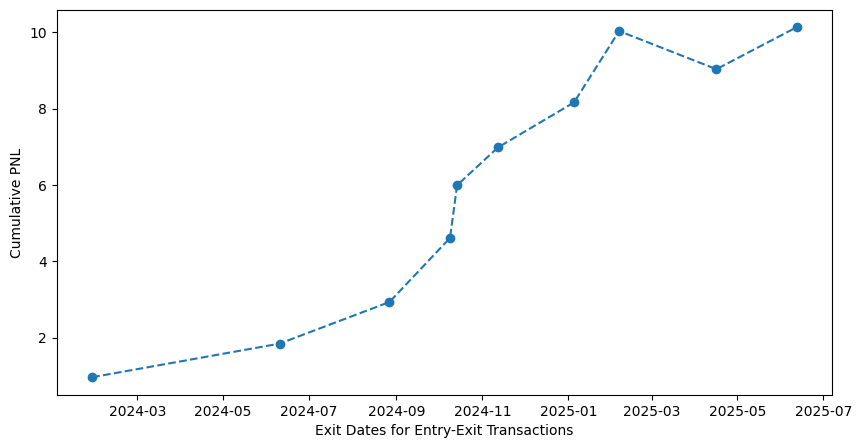

In [52]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(date_objects, pnl,marker='o', linestyle='dashed')
plt.xlabel('Exit Dates for Entry-Exit Transactions')
plt.ylabel('Cumulative PNL')